In [7]:
import numpy as np
from anytree import Node, RenderTree
import networkx as nx
import matplotlib.pyplot as plt
import random
import io, sys, os
import pandas as pd
from IPython.display import display
from collections import defaultdict

In [8]:
def spectral_guess(A, k, eval = 0, evec = 0, max_iter=1000):
    n = A.shape[0]
    # Calculate degrees of vertices
    degrees = np.sum(A, axis=1)
    # Create the degree matrix
    D = np.diag(degrees)
    # Calculate the Laplacian matrix
    L = D - A
    # Get the eigenvectors of the graph
    eigvals, eigvecs = np.linalg.eig(L)
    # Get the indices of the k largest eigenvectors
    idx = np.argpartition(eigvals, 1-k)[1-k:]
    # Get the eigenvectors corresponding to the k-1 largest eigenvalues
    X = eigvecs[:, idx]
    
    if eval == 1:
        print("Eigenvalues: ", eigvals[idx])
    if evec == 1:
        print("Eigenvectors: ", X)

    # Initialize the centroids to the first k rows of X
    centroids = X[:k]
    # Initialize the cluster assignments to -1
    clusters = np.full(n, -1)
    for _ in range(max_iter):
        # Assign each node to the nearest centroid
        for i in range(n):
            clusters[i] = np.argmin(np.linalg.norm(centroids - X[i], axis=1))
        # Update the centroids
        new_centroids = np.array([np.mean(X[clusters == i], axis=0) for i in range(k)])
        # If the centroids haven't changed, return the clusters
        if np.array_equal(centroids, new_centroids):
            continue
        centroids = new_centroids
    
    z = clusters.tolist()

    result = 0
    for i in range(n):
        for j in range(i+1,n):
            if z[i] != z[j]:
                result += A[i][j]
    return [z, float(result)]

In [ ]:
class LazyBranchAndBound:
    def __init__(self, A, k, initial_guess = 0):
        # Validate inputs
        if not isinstance(k, int) or not isinstance(A, np.ndarray):
            raise ValueError("k must be an integer and A must be a numpy array")
        
        n = A.shape[0]
        if k > n:
            raise ValueError("k must be less than n")
        
        if A.shape[0] != A.shape[1]:
            raise ValueError("A must be a square matrix")
        
        if not np.all(A >= 0):
            raise ValueError("A must contain only non-negative values")
        
        if not np.allclose(A, A.T):
            raise ValueError("A must be symmetric")
        
        if not isinstance(initial_guess, (int, float)) or initial_guess < 0:
            raise ValueError("initial_guess must be a non-negative number")
        
        
        # Calculate degrees of vertices
        degrees = np.sum(A, axis=1)
        
        # Get the sorted indices based on degrees
        sorted_indices = np.argsort(degrees)
        
        # Reorder the matrix A based on sorted indices
        A = A[sorted_indices, :][:, sorted_indices]
        
        self.A = A #Reordered matrix greatly improves performance.
        self.k = k
        self.n = n
        self.best_guess = (initial_guess, [])
        self.root = Node(("root", []), bound=float('inf'))

    def get_address(self, node):
        if node.is_root:
            return []
        return [node.name[0]] + node.parent.name[1] #Addresses are written in reverse to go from n down to 1.

    def _bound(self, node):
        """
        Computes the upper bound for a given node.
        For now, it returns +infinity as a dummy upper bound.

        :param node: The node for which to compute the upper bound.
        :return: The computed upper bound.
        """
        
        address = node.name[1]
        l = len(address)

        if l <= 1: #To stop unnecessary computation at the start.
            return [float('inf')]
        
        if l >= self.n: #DEBUG LINE
            print("Address at " + str(address) + " is " + str(l) + " long")
            return [float('inf')]

        
        #Term 0 (|m_0|= 0)
        Al = self.A[:self.n-l, :self.n-l] #Accounting for 0-indexing
        b0x = self.k*0.5*np.sum(self.A)

        # Convert address to a NumPy array
        address_array = np.array(address)
        # Create the Del matrix using broadcasting
        Del = (address_array[:, None] == address_array[None, :]).astype(int)
        b0y = (-1)*0.5*self.k*np.sum(np.multiply(Del,self.A[self.n-l:,self.n-l:,]))
        
        b0z = (-1)*0.5*np.sum(Al) #This looks like term 1 a lot, let's cancel out later.
        
        b0 = b0x+b0y+b0z
        """
        Actually pretty good - greedy search looks promising!
        Fourier sparsity => Smoothness => Low Variance => Greedy works well. 
        """

        if b0 < 0: #DEBUG LINE, this should never be less than 0.
            print("Average is negative? Term 3 is " +str(b0) + " at " + str(address))
        
        #Term 1 (|m_0|= 1) NEED TO DEBUG THIS, WHY IS BOUND NOT WORKING?
        
        Alr = self.A[:self.n-l, self.n-l:] #Accounting for 0-indexing
        b1 = np.sum(Alr) 
        level_sets = defaultdict(list)
        for idx, value in enumerate(address):
            level_sets[value].append(idx+self.n-l)

        level_sets = dict(level_sets)
        levels = level_sets.keys()
        if len(levels) == self.k:
            C = np.zeros((self.n-l,self.k))
            for j in levels:
                for t in level_sets[j]:
                    C[:,j] += self.A[:self.n-l,t]

            for s in range(self.n-l):
                b1 += -np.min(C[s])
        
        #
        """
        b1 = 0
        b1r = 0
        for s in range(self.n-l):
            for t in range(1,self.k):
                for r in range(l):
                    b1r += self.A[s][r+self.n-l] * np.exp((-1)*2*np.pi * 1j * t*address[r]/self.k)
                b1 += abs(b1r)

        """
        """
        This term needs to be much more efficiently implemented.
        There might be some cancellation with the different t and r.
        STARTS HORRIBLY INEFFICIENT, gets better after l = n/2.
        """
        
        if l == 2:
            return [b0/self.k,b1*(self.k-1)/self.k,0] #Since there's no 2-modes yet.

        #Term 2 (|m_0|= 2) 
        b2 = 0
        b2 += np.sum(Al)*self.k*0.5 #These factors of 0.5 are because we're iterating over all pairs of the Fourier mode components (m_s,m_t) for all s,t.
        """
        Part of this term is cancelled out by the last part of Term 3.
        Need spectral methods for large n.
        """

        b0 = float(b0)
        b1 = float(b1)
        b2 = float(b2)     
        
        return [b0/self.k,b1*(self.k-1)/self.k,b2/self.k] #There's no factor of half anymore, mistake carried from thesis and early calculations.
    
    def value(self, node):
        # Check if the node is an nth child of the root
        if node.depth != self.n: #DEBUG LINE
            return print(str(node.name[1]) + " tried to be evaluated rather than bounded")
        
        # Use the address directly
        z = node.name[1]
        
        result = 0
        for i in range(self.n):
            for j in range(i+1,self.n):
                if z[i] != z[j]:
                    result += self.A[i][j]
        
        return result
    
    def _branch(self, node):
        #Only create one child for the root node, this is the beginnings of the overall branching simplification.
        if node == self.root:
            child = Node((0, [0]),parent=node)
            child.bound = float('inf')
            return

        if len(node.name[1]) >= self.n: #DEBUG LINE
            print(str(node.name[1]) + " tried to have children") 
            return #Is creating extra nodes beyond depth n, this is a temporary fix.
        
        if len(node.name[1]) == self.n-1:
            for i in range(self.k):
                child = Node((i, [i] + node.name[1]), parent=node)
                child.value = self.value(child)
            return

        # Create k children nodes
        for i in range(self.k): 
            child = Node((i, [i] + node.name[1]), parent=node)
            child.bound = sum(self._bound(child))
            if node:
                if child.bound > node.bound:
                    child.bound = node.bound
        return

    def _prune(self, node):
        # Recursively delete all children
        for child in node.children:
            self._prune(child)
        # Detach the node from its parent and delete it
        node.parent = None
        del node
    """
    DEPRECATED
    def _prune_ancestors(self, node): # This is not working as intended, trying to prune ancestors if they have no remaining children to save on memory.
        parent = node.parent
        while parent and not parent.is_root and len(parent.children) == 0:
            grandparent = parent.parent
            parent.parent = None
            del parent
            parent = grandparent
    """
    def search(self, updates=False): # Add updates parameter with default value False
        stack = [self.root]
        best_guess_node = None
        
        while stack:  # While stack is not empty
            node = stack.pop()
            if len(node.name[1]) != node.depth: #DEBUG LINE
                print("length of " + str(node.name[1]) + " is not equal to its depth " + str(node.depth))
                
            if len(node.name[1]) < self.n:
                if node.bound >= self.best_guess[0]:
                    self._branch(node)
                    for child in node.children:
                        stack.append(child)
                else:
                    # Prune the node and its children
                    self._prune(node)
                    
            elif len(node.name[1]) == self.n:
                # Compute value for the node. Sibling strategy yet to be implemented.
                parent = node.parent
                if parent: #This stops excessive breeding.
                    value = node.value
                    if value < self.best_guess[0]:
                        self._prune(node)
                            
                    else:
                        self.best_guess = [float(value), node.name[1]]
                        if updates:  # Print only if updates is True
                            print("New Best guess:" + str(self.best_guess))
                            
                        # Remove the old best_guess node from the stack and the tree
                        if best_guess_node in stack:
                            stack.remove(best_guess_node)
                        if best_guess_node:
                            self._prune(best_guess_node)
                                
                        # Update the best_guess_node
                        best_guess_node = node
                else: 
                    print(str(node.name[1]) + " somehow exists without a parent") #DEBUG LINE
        
        return self.best_guess




In [20]:
def randdataset(N, m, D, dataset=None, seed=None, weights = None, name = None): 

    if seed is not None:
            random.seed(seed)  # Set seed for reproducibility
            np.random.seed(seed)
            print("Seed set to " + str(seed))

    if dataset is None:  # Initialize the dataset dictionary
        dataset = {}
    
    if m == 0:  # Base case: when no more graphs need to be generated
        return [name, dataset]
    
    # Generate a random graph
    G = nx.gnp_random_graph(N[-1], D[-1])  
    if weights is not None:
        for (u, v) in G.edges():
            G[u][v]['weight'] = random.uniform(weights[0], weights[1])
    
    N = N[:-1]  # Remove the last element of N
    D = D[:-1]  # Remove the last element of D
    A = nx.to_numpy_array(G, dtype=float)  
    
    # Store it in the dataset
    dataset[m - 1] = (A, G)  # Using m-1 to maintain consistency with the original for-loop

    # Recursive call for the remaining m-1 graphs
    return randdataset(N, m - 1, D, dataset, name = name)


def test(data, k, initial_guess, showT = True, showG = True, updates = False, name = None):
    A = data[0]
    G = data[1]

    if showG:
        num_vertices = G.number_of_nodes()
        num_edges = G.number_of_edges()

        # Calculate figure size based on the number of vertices and edges
        width = 8 + num_vertices * 0.1
        height = 6 + num_edges * 0.05

        fig, ax = plt.subplots(figsize=(width, height))
        nx.draw(G, ax=ax, with_labels=True, node_color='lightblue', edge_color='white', node_size=500, font_size=10, font_color='white')
        plt.title(name, color='white')  # Set the title color to white
        ax.set_facecolor('gray')  # Set the background color to black
        ax.axis('off')  # Turn off the axis
        fig.set_facecolor('gray')  # Set the figure background color to black
        plt.show()
        
        pass

    bb = LazyBranchAndBound(A, k, initial_guess)
    Optima = bb.search(updates)
    Max = float(round(Optima[0],2))
    Arg = Optima[1]

    count = 0
    for pre, fill, node in RenderTree(bb.root): #fill is just a filler variable because of how RenderTree works.
        count += 1
        if showT:
            if len(node.name[1]) < bb.n:
                bounds = bb._bound(node)  # Get the bounds [b1, b2, b3]
                print(f'{pre} {node.depth} {node.name[1]} {bounds}')
                #print(f'{pre} {node.depth} {node.name[1]} {float(round(node.bound,2))}')
            else: print(f'{pre} {node.depth} {node.name[1]} {float(round(bb.value(node),2))}')

    percentage_pruned = float(np.round(((1 - count * (bb.k - 1) / (bb.k**(bb.n - 1) - 1)) * 100), 2)) #How many nodes the tree pruned / didn't check.

    result = [Max,Arg,percentage_pruned]

    if showG:
        present(result, eff = True, max = True, arg = True)
    
    return result

def multitest(dataset, K, guesses, showG = True, showT = False, i=0, results=None):  
    if results is None:  
        results = [[], [], []]  # Initialize the results list

    if i >= len(K):  # Correctly compare integer i to length of K
        return results
    
    # Call test and store its result
    result = test(dataset[1][i], K[i], guesses[i], showG = showG, showT = showT, name = dataset[0])
    testmax = result[0]
    testarg = result[1]
    testeff = result[2]

    # Append the result (percentage pruned) to results
    results[0].append(testmax)
    results[1].append(testarg)
    results[2].append(testeff)
    
    # Continue recursion
    return multitest(dataset, K, guesses, showG, showT, i+1, results)  # Pass the results list down the recursion

def present(result, eff = True, max = False, arg =False):
    if eff:
        print("The percentage pruned for the graph is: " + str(result[2]))
    if max:
        print("The maxima found for the graph is: " + str(result[0]))
    if arg:
        print("The maximisers for the graph is: " + str(result[1]))
    return

def multipresent(results, eff = True, max = False, arg =False):
    if eff:
        print("The percentage pruned for each dataset is: " + str(results[2][:]))
    if max:
        print("The maxima found for each dataset are: " + str(results[0][:]))
    if arg:
        print("The maximisers for each dataset are: " + str(results[1][:]))
    return

In [11]:
def statistics(results):
    mean = float(round(np.mean(results[2]), 2))
    median = float(round(np.median(results[2]), 2))
    std = float(round(np.std(results[2]), 2))
    return [mean, median, std]

In [ ]:
#Parameters for Dataset Construction
#Size of each dataset (number of graphs)
m=50

# Number of vertices for graphs in a certain range
v = 10
V = 10
N = [random.randint(v,V) for i in range(m)]
print(N)

# Weight range for the weighted graphs
w = 0.1
W = 1

# Special Parameters
eps = 0.05 #Should be between 0.01 and 0.1.

[20, 17, 16, 15, 17, 19, 17, 18, 19, 19, 16, 16, 15, 19, 17, 20, 19, 17, 20, 17, 17, 20, 20, 16, 15, 15, 17, 20, 17, 16, 20, 15, 17, 17, 17, 20, 19, 20, 19, 15, 15, 17, 17, 19, 15, 16, 18, 17, 20, 19]


In [449]:
# Unweighted Datasets
UnweightedDatasets = {}
UnweightedDatasets['Isolated'] = randdataset(N, m, [1/i for i in N], name='Isolated')
UnweightedDatasets['Transitioning to Connectivity'] = randdataset(N, m, [float(np.log2(i)/i) for i in N], name='Transitioning to Connectivity')
UnweightedDatasets['Extremely Sparse'] = randdataset(N, m, [float(1/np.sqrt(i)) for i in N], name='Extremely Sparse')
UnweightedDatasets['Very Sparse'] = randdataset(N, m, [0.1 for i in N], name='Very Sparse')
UnweightedDatasets['Moderately Sparse'] = randdataset(N, m, [0.25 for i in N], name='Moderately Sparse')
UnweightedDatasets['Moderately Dense'] = randdataset(N, m, [0.5 for i in N], name='Moderately Dense')
UnweightedDatasets['Very Dense'] = randdataset(N, m, [0.75 for i in N], name='Very Dense')
#UnweightedDatasets['Extremely Dense'] = randdataset(N, m, [1-eps for i in N], name='Extremely Dense')
#UnweightedDatasets['Complete'] = randdataset(N, m, [1 for i in N], name='Complete')

# Weighted Datasets
WeightedDatasets = {}
WeightedDatasets['Isolated'] = randdataset(N, m, [1/i for i in N], weights=(w, W), name='Isolated')
WeightedDatasets['Transitioning to Connectivity'] = randdataset(N, m, [float(np.log2(i)/i) for i in N], weights=(w, W), name='Transitioning to Connectivity')
WeightedDatasets['Extremely Sparse'] = randdataset(N, m, [float(1/np.sqrt(i)) for i in N], weights=(w, W), name='Extremely Sparse')
WeightedDatasets['Very Sparse'] = randdataset(N, m, [0.1 for i in N], weights=(w, W), name='Very Sparse')
WeightedDatasets['Moderately Sparse'] = randdataset(N, m, [0.25 for i in N], weights=(w, W), name='Moderately Sparse')
WeightedDatasets['Moderately Dense'] = randdataset(N, m, [0.5 for i in N], weights=(w, W), name='Moderately Dense')
WeightedDatasets['Very Dense'] = randdataset(N, m, [0.75 for i in N], weights=(w, W), name='Very Dense')
#WeightedDatasets['Extremely Dense'] = randdataset(N, m, [1-eps for i in N], weights=(w, W), name='Extremely Dense')
#WeightedDatasets['Complete'] = randdataset(N, m, [1 for i in N], weights=(w, W), name='Complete')

In [450]:
# Testing of the algorithm over various datasets for the two-cut problem
U2Cut = {}
for key in UnweightedDatasets.keys():
    U2Cut[key] = multitest(UnweightedDatasets[key], [2 for i in range(m)], [0 for i in range(m)], showG = False)
    print("Dataset: " + key)

W2Cut = {}
for key in WeightedDatasets.keys():
    W2Cut[key] = multitest(WeightedDatasets[key], [2 for i in range(m)], [0 for i in range(m)], showG = False)
    print("Dataset: " + key)

Dataset: Isolated
Dataset: Transitioning to Connectivity
Dataset: Extremely Sparse
Dataset: Very Sparse
Dataset: Moderately Sparse
Dataset: Moderately Dense
Dataset: Very Dense
Term 3 in the bound is -8.881784197001252e-16 at [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Term 3 in the bound is -8.881784197001252e-16 at [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Dataset: Isolated
Dataset: Transitioning to Connectivity
Dataset: Extremely Sparse
Dataset: Very Sparse
Dataset: Moderately Sparse
Dataset: Moderately Dense
Dataset: Very Dense


In [451]:
# Testing of the algorithm over various datasets for the three-cut problem
U3Cut = {}
for key in UnweightedDatasets.keys():
    #U3Cut[key] = multitest(UnweightedDatasets[key], [3 for i in range(m)], [0 for i in range(m)], showG = False)
    U3Cut[key] = [None]

W3Cut = {}
for key in WeightedDatasets.keys():
    #W3Cut[key] = multitest(WeightedDatasets[key], [3 for i in range(m)], [0 for i in range(m)], showG = False)
    W3Cut[key] = [None]

In [452]:
# Testing of the algorithm over various datasets for the four-cut problem
U4Cut = {}
for key in UnweightedDatasets.keys():
    #U4Cut[key] = multitest(UnweightedDatasets[key], [4 for i in range(m)], [0 for i in range(m)], showG = False)
    U4Cut[key] = [None]

W4Cut = {}
for key in WeightedDatasets.keys():
    #W4Cut[key] = multitest(WeightedDatasets[key], [4 for i in range(m)], [0 for i in range(m)], showG = False)
    W4Cut[key] = [None]

In [453]:
UCut = {2: U2Cut, 3: U3Cut, 4: U4Cut}
WCut = {2: W2Cut, 3: W3Cut, 4: W4Cut}

In [454]:
# Create a dictionary to hold the statis
UStats = {2: [], 3: [], 4: []}
WStats = {2: [], 3: [], 4: []}

# Populate the dictionary with the performance statistics
for key in UnweightedDatasets.keys():
    UStats[2].append(statistics(UCut[2][key]))
    #UStats[3].append(statistics(UCut[3][key]))
    #UStats[4].append(statistics(UCut[4][key]))
    WStats[2].append(statistics(WCut[2][key]))
    #WStats[3].append(statistics(WCut[3][key]))
    #WStats[4].append(statistics(WCut[4][key]))

In [ ]:
# Unweighted datasets performance
U2Performance = pd.DataFrame(UStats[2], index=UnweightedDatasets.keys())
U2Performance.columns = ['Mean', 'Median', 'Standard Deviation']
U2Performance.name = "k = 2, Unweighted"

"""U3Performance = pd.DataFrame(UStats[3], index=UnweightedDatasets.keys())
U3Performance.columns = ['Mean', 'Median', 'Standard Deviation']
U3Performance.name = "k = 3, Unweighted"

U4Performance = pd.DataFrame(UStats[4], index=UnweightedDatasets.keys())
U4Performance.columns = ['Mean', 'Median', 'Standard Deviation']
U4Performance.name = "k = 4, Unweighted"
"""
# Weighted datasets performance
W2Performance = pd.DataFrame(WStats[2], index=WeightedDatasets.keys())
W2Performance.columns = ['Mean', 'Median', 'Standard Deviation']
W2Performance.name = "k = 2, Weighted"

"""W3Performance = pd.DataFrame(WStats[3], index=WeightedDatasets.keys())
W3Performance.columns = ['Mean', 'Median', 'Standard Deviation']
W3Performance.name = "k = 3, Weighted"

W4Performance = pd.DataFrame(WStats[4], index=WeightedDatasets.keys())
W4Performance.columns = ['Mean', 'Median', 'Standard Deviation']
W4Performance.name = "k = 4, Weighted"
"""

In [456]:
# Display DataFrames with their names
print(U2Performance.name)
display(U2Performance)

print(W2Performance.name)
display(W2Performance)

"""print(U3Performance.name)
display(U3Performance)

print(W3Performance.name)
display(W3Performance)

print(U4Performance.name)
display(U4Performance)

print(W4Performance.name)
display(W4Performance)"""

k = 2, Unweighted


Mean  Median  Standard Deviation
Isolated                       79.62   82.06               14.82
Transitioning to Connectivity  79.30   81.84                9.11
Extremely Sparse               80.32   81.54                5.78
Very Sparse                    84.38   86.30                8.85
Moderately Sparse              79.36   80.09                9.00
Moderately Dense               67.09   68.56                7.64
Very Dense                     44.82   45.40                6.69

k = 2, Weighted


Mean  Median  Standard Deviation
Isolated                       82.28   84.76               11.72
Transitioning to Connectivity  79.31   80.76                7.57
Extremely Sparse               80.87   80.27                6.99
Very Sparse                    84.61   87.24                8.04
Moderately Sparse              79.33   81.02                6.88
Moderately Dense               64.64   65.72                7.83
Very Dense                     47.22   47.71                5.52

'print(U3Performance.name)\ndisplay(U3Performance)\n\nprint(W3Performance.name)\ndisplay(W3Performance)\n\nprint(U4Performance.name)\ndisplay(U4Performance)\n\nprint(W4Performance.name)\ndisplay(W4Performance)'

In [27]:
# Assuming v, V, and m are defined somewhere in your notebook

# Create the base string 'trial'
base_trial = f'{v}-{V}_{m}'

# Find the next available directory name
i = 0
while os.path.exists(f'Data/{base_trial}_{i}'):
    i += 1

# Create the final directory name
trial = f'{base_trial}_{i}'
directory = f'Data/{trial}'
os.makedirs(directory, exist_ok=True)

# Save the dataframes to CSV files
U2Performance.to_csv(f'{directory}/U2Performance.csv')
W2Performance.to_csv(f'{directory}/W2Performance.csv')

# Uncomment the following lines if you want to save the other dataframes as well
# U3Performance.to_csv(f'{directory}/U3Performance.csv')
# W3Performance.to_csv(f'{directory}/W3Performance.csv')
# U4Performance.to_csv(f'{directory}/U4Performance.csv')
# W4Performance.to_csv(f'{directory}/W4Performance.csv')

In [12]:
X = randdataset([20], 1, [0.3], name = '10 Vertex Graph with 0.3 edge probability')

In [19]:
B = spectral_guess(X[1][0][0], 2, eval = 1, evec = 1)
print(B)

Eigenvalues:  [13.09472417]
Eigenvectors:  [[ 0.08310585]
 [ 0.05478312]
 [-0.04085689]
 [-0.36024239]
 [ 0.20807102]
 [ 0.03142055]
 [ 0.11462053]
 [ 0.20093183]
 [-0.0957463 ]
 [ 0.12399945]
 [ 0.09021933]
 [ 0.11911397]
 [-0.08093887]
 [ 0.09491737]
 [ 0.25959802]
 [-0.19833826]
 [-0.03444476]
 [ 0.20218536]
 [-0.03170672]
 [-0.7406922 ]]
[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], 28.0]


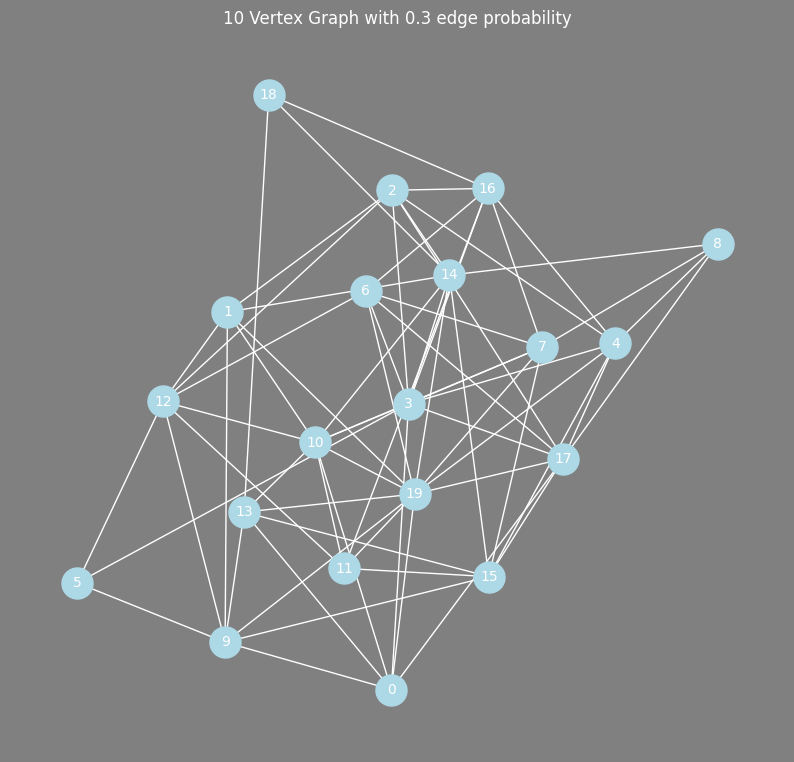

 0 [] [inf]
└──  1 [0] [inf]
    ├──  2 [0, 0] [np.float64(44.0), np.float64(10.5), 0]
    │   ├──  3 [0, 0, 0] [45.5, 13.0, 39.0]
    │   │   ├──  4 [0, 0, 0, 0] [46.5, 15.0, 33.0]
    │   │   │   ├──  5 [0, 0, 0, 0, 0] [46.0, 16.0, 28.0]
    │   │   │   │   ├──  6 [0, 0, 0, 0, 0, 0] [48.0, 18.5, 22.0]
    │   │   │   │   │   ├──  7 [0, 0, 0, 0, 0, 0, 0] [45.5, 18.0, 19.0]
    │   │   │   │   │   │   ├──  8 [0, 0, 0, 0, 0, 0, 0, 0] [47.5, 20.5, 13.0]
    │   │   │   │   │   │   │   ├──  9 [0, 0, 0, 0, 0, 0, 0, 0, 0] [48.0, 22.0, 8.0]
    │   │   │   │   │   │   │   │   ├──  10 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [42.5, 19.5, 7.0]
    │   │   │   │   │   │   │   │   │   ├──  11 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [40.0, 19.0, 4.0]
    │   │   │   │   │   │   │   │   │   │   ├──  12 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [36.0, 17.5, 2.0]
    │   │   │   │   │   │   │   │   │   │   │   └──  13 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [36.5, 15.0, 1.0]
    │   │   │   │   │   │   │   │   │   │   └

In [18]:
Results = multitest(X, [2], [B[1]],showG = 1, showT = 1)

In [61]:
print(Results)

[[11.0], [[1, 1, 0, 1, 2, 2, 2, 0, 1, 0]], [75.86]]


Monte-Carlo sampling of the graphs to plot percentages?
Do fixed number of vertices and plot efficiency over size graph.
Also need to improve search algorithm - look into the largest bound coset first. (Need to put bound into branch function)
STORE SEEDS FROM TESTS.

To do:
Write up Z_k^n
Read up on FFT for Compact Groups.
Implement Greedy Average Search.
Optimize the code. Run the tests.